In [1]:
%reload_ext autoreload
%autoreload 2
# !pip install --upgrade transformers 
# which python
# !pip install -q transformers
# !pip install -q datasets
# !pip install -q evaluate
# !pip install -q accelerate
# !pip install -q gluonts ujson

# Tutoial directly gotten from https://huggingface.co/blog/time-series-transformers


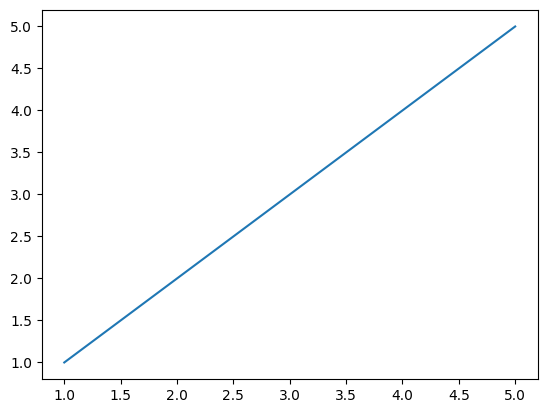

<Figure size 640x480 with 0 Axes>

In [302]:
import matplotlib.pyplot as plt 

plt.plot([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])
plt.draw()
plt.savefig("asdasdasd.png")
plt.pause(0.1)  # Adjust the duration as needed
plt.clf()

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

df = pd.read_csv("../../datasets/household_power_consumption.txt", sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
print("Length of dataset", len(df))
print(df.head())
df.describe()

Length of dataset 2075259
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
200

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [3]:
# filling nan with mean in any columns
print("Before:",df.isnull().sum())
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
print("After:", df.isnull().sum())

Before: Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
After: Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [4]:
# here we split the data into different granularity (hours, days, weeks, months)
df_minute = df
df_hours = df.resample("h").mean()
df_days = df.resample("D").mean()
df_weeks = df.resample("W").mean()
df_months = df.resample("M").mean()
print("Length of minute dataset:", len(df_minute))
print("Length of hours dataset:", len(df_hours))
print("Length of days dataset:", len(df_days))
print("Length of weeks dataset:", len(df_weeks))
print("Length of months dataset:", len(df_months))

# print("---MINUTE---")
# print(df_minute.head())
# print("---HOURS---")
# print(df_hours.head())
print("---DAYS---")
print(df_days.head())
# print("---WEEKS---")
# print(df_weeks.head())
# print("---MONTHS---")
# print(df_months.head())
print(df_days.keys())

Length of minute dataset: 2075259
Length of hours dataset: 34589
Length of days dataset: 1442
Length of weeks dataset: 207
Length of months dataset: 48
---DAYS---
            Global_active_power  Global_reactive_power     Voltage  \
dt                                                                   
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
dt                                                                            
2006-12-16         13.082828        0.000000        1.378788       12.439394  
2006-12-17          9.999028        1.411806        2.907639        9.264583  
2006-12-18          6.421667  

In [5]:
from gluonts.dataset.common import ListDataset
# Data splitting 
from gluonts.dataset.field_names import FieldName
from sklearn.preprocessing import MinMaxScaler
# Choosing prediction column 
n_cols = 1
# For now I am only using Global_active_power to predict Global_active_power (days)
# dataset = df["Global_active_power"]
dataset = df_days["Global_active_power"]
# dataset = df_hours["Global_active_power"]
dataset = pd.DataFrame(dataset)

# All the hyperparameters here including the patch sizes are the same as delhi.ipynb just to keep things consistent
data = dataset.values
scaler = MinMaxScaler(feature_range= (0, 1))
# scaled_data = scaler.fit_transform(np.array(data))

scaled_data = np.array(data)
scaled_data = scaled_data.reshape(scaled_data.shape[0])
train_size = int(len(scaled_data) * 0.5)
val_size = int(0.75 * len(scaled_data)) - train_size
train_data = scaled_data[0:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]
prediction_length = 24 # 24 days 
freq = "1D" # set frequency to 1 day
# target, feat_dynamic_real, feat_static_cat = data_out
def getTarget(patch, stride, data_list):
    
    target = []
    for i in range(patch, len(data_list), stride):
        target.append(data_list[i-patch:i])
    # Convert to numpy array
    target = np.array(target)
    # Reshaping the input to (n_samples, time_steps, n_feature)
    # target = np.reshape(target, (target.shape[0], target.shape[1], n_cols))
    return target
# TODO: why is the start date not changing? MIGHT NEED TO FIX
train_target = getTarget(7 * 24, 1, train_data)
feat_static_cat = [i for i in range(len(train_target))]
train_start =  [pd.Period("16-12-2006", freq=freq) for _ in range(len(train_target))]
print(train_target.shape)
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fsc) in zip(
            train_target[:, :-prediction_length],
            train_start,
            feat_static_cat,
        )
    ],
    freq=freq,
)

val_target = getTarget(7 * 24, 1, val_data)
val_start =  [pd.Period("06-12-2008", freq=freq) for _ in range(len(val_target))]
val_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fsc) in zip(
            val_target[:, :-prediction_length],
            val_start,
            feat_static_cat,
        )
    ],
    freq=freq,
)


test_target = getTarget(7 * 24, 1, test_data)
test_start =  [pd.Period("01-12-2009", freq=freq) for _ in range(len(test_target))] 
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fsc) in zip(
            test_target[:, :-prediction_length],
            test_start,
            feat_static_cat,
        )
    ],
    freq=freq,
)
print(len(test_ds), len(test_ds[0]["target"]))

(553, 168)
193 144


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3382: UserWarning: Parsing '16-12-2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  if await self.run_code(code, result, async_=asy):


In [6]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# train_example = dataset['train'][0]
# print(train_example.keys())
# validation_example = dataset['validation'][0]
# test_example = dataset['test'][0]
# print(dataset['train'][0]["start"])
# print(len(dataset['train'][0]["target"]))
# print(dataset['train'][4]["start"])
# print(len(dataset['train'][4]["target"]))

In [8]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [9]:
from functools import partial
# train_dataset = dataset["train"]
# test_dataset = dataset["test"]
train_dataset = train_ds
test_dataset = test_ds

    
# freq = "1D"
# freq = "1M"
# train_dataset.set_transform(partial(transform_start_field, freq=freq))
# test_dataset.set_transform(partial(transform_start_field, freq=freq))
# print(train_dataset["start"])
# print(train_dataset[0].keys())
# print(train_ds[0].keys())

In [10]:
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str

# The look back window, in this case how many days we consider 
lags_sequence = get_lags_for_frequency(freq)
time_features = time_features_from_frequency_str(freq)

print(lags_sequence)
print(time_features)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]
[<function day_of_week at 0x000002679B4D27A0>, <function day_of_month at 0x000002679B4D28C0>, <function day_of_year at 0x000002679B4D29E0>]


In [11]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # # How many inputs the model take into account when 
    context_length=prediction_length * 2, 
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,# TODO: understand this 
    # day of year, day of months, and day of week
    num_time_features=len(time_features),
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],# TODO: understand this 
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32, 
)

model = TimeSeriesTransformerForPrediction(config)

In [12]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # We use days of week, days of months, and days of years in this case 
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            # AddAgeFeature(
            #     target_field=FieldName.TARGET,
            #     output_field=FieldName.FEAT_AGE,
            #     pred_length=config.prediction_length,
            #     log_scale=True,
            # ),
            # # step 6: vertically stack all the temporal features into the key FEAT_TIME
            # VstackFeatures(
            #     output_field=FieldName.FEAT_TIME,
            #     input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
            #     + (
            #         [FieldName.FEAT_DYNAMIC_REAL]
            #         if config.num_dynamic_real_features > 0
            #         else []
            #     ),
            # ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )
    
    
    
# transformation = create_transformation(freq, config)
# transformed_data = transformation.apply(train_dataset, is_train=False)
# print(next(iter(transformed_data))["time_features"].shape)
# print(train_dataset[0].keys())

# print(next(iter(transformed_data))["time_features"][0])
# # print(train_dataset[0]["target"])
# time_features_from_frequency_str(freq)[0](train_dataset[0]["start"])

In [13]:


from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )
    
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [14]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)
# i = 0
# for j in test_dataloader:
#     i+=1
#     print(j.keys())
#     print(j["past_time_features"].shape)
#     print(j["past_values"].shape)
#     print(j["past_observed_mask"].shape)
#     print(j["future_time_features"].shape)
#     print(j["static_categorical_features"].shape)

# print(len(test_dataset[0]["target"]))

In [15]:

batch = next(iter(train_dataloader))
# perform forward pass
print(batch.keys())
# dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])
# dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])

outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)
print("Loss:", outputs.loss.item())


dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])
Loss: 1.6156471967697144


In [16]:
from accelerate import Accelerator
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler


accelerator = Accelerator()
device = accelerator.device

def train(model, data_loader, epoch):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    model, optimizer, data_loader = accelerator.prepare(
        model,
        optimizer,
        data_loader,
    )
    model.train()
    print("-------------TRAINING START-------------")
    print("Training with epoch: " + str(epoch))
    for epoch in range(epoch):
        for idx, batch in enumerate(data_loader):
            optimizer.zero_grad()
            outputs = model(
                static_categorical_features=batch["static_categorical_features"].to(device)
                if config.num_static_categorical_features > 0
                else None,
                static_real_features=batch["static_real_features"].to(device)
                if config.num_static_real_features > 0
                else None,
                past_time_features=batch["past_time_features"].to(device),
                past_values=batch["past_values"].to(device),
                future_time_features=batch["future_time_features"].to(device),
                future_values=batch["future_values"].to(device),
                past_observed_mask=batch["past_observed_mask"].to(device),
                future_observed_mask=batch["future_observed_mask"].to(device),
            )
            loss = outputs.loss

            # Backpropagation
            accelerator.backward(loss)
            optimizer.step()

            if idx % 100 == 0:
                print(loss.item())
        scheduler.step()
    print("-------------TRAINING END-------------")
    return model
    

In [17]:

model = train(model, train_dataloader, 5)

-------------TRAINING START-------------
Training with epoch: 5
1.7412118911743164
0.5769808292388916
0.4328378140926361
0.2832714021205902
0.22806598246097565
-------------TRAINING END-------------


In [18]:
def evaluate(model, data_loader):
    model.eval()

    forecasts = []

    for batch in data_loader:
        outputs = model.generate(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
        )
        forecasts.append(outputs.sequences.cpu().numpy())
        
    forecasts = np.vstack(forecasts)
    return forecasts


In [ ]:
def evaluate(model, data_loader):
    model.eval()

    forecasts = []

    for batch in data_loader:
        outputs = model.generate(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
        )
        forecasts.append(outputs.sequences.cpu().numpy())
        
    forecasts = np.vstack(forecasts)
    return forecasts


In [19]:

forecasts = evaluate(model, test_dataloader)

In [20]:
# i = 0
# for _ in train_dataloader:
#     print(_["past_time_features"][0])
#     i+=1
    
# len(test_target)
forecasts

array([[[ 1.4132658 ,  0.90875584,  0.6653242 , ...,  1.827254  ,
          0.9825095 ,  1.5760914 ],
        [ 1.2282932 ,  0.7021942 ,  1.0461419 , ...,  0.61983854,
          0.3748556 ,  0.9514347 ],
        [ 1.0489653 ,  0.7924804 ,  0.74026555, ...,  1.2974224 ,
          1.1818937 ,  1.5796019 ],
        ...,
        [ 1.370518  ,  0.9715326 ,  1.1164689 , ...,  1.0176661 ,
          0.964871  ,  0.63636076],
        [ 1.2746218 ,  0.980902  ,  0.78188264, ...,  0.79120755,
          0.21435122,  0.6928153 ],
        [ 1.2153094 ,  1.4016051 ,  1.1790514 , ...,  0.9094129 ,
          0.6490408 ,  0.97647643]],

       [[ 1.3839378 ,  1.0822213 ,  1.0230149 , ...,  0.51992977,
          0.14799277,  0.62847227],
        [ 0.8435419 ,  1.0934894 ,  0.8154412 , ...,  0.79012126,
          1.1084516 ,  0.8680688 ],
        [ 0.7745433 ,  1.1532085 ,  1.3539393 , ...,  1.1205506 ,
          0.56560785,  1.3354244 ],
        ...,
        [ 0.69405437,  0.81727415,  1.2005674 , ...,  

In [54]:
from evaluate import load
from gluonts.time_feature import get_seasonality
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def calculate(forecasts, dataset):
    # scaler.fit_transform(np.array(forecasts))
    mse_metric = load("evaluate-metric/mse")
    mase_metric = load("evaluate-metric/mase")
    smape_metric = load("evaluate-metric/smape")

    forecast_median = np.median(forecasts, 1)

    mse_metrics = []
    mase_metrics = []
    smape_metrics = []
    for item_id, ts in enumerate(dataset):
        training_data = ts["target"][:-prediction_length]
        ground_truth = ts["target"][-prediction_length:]
        mse = mse_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth)
            )
        mse_metrics.append(mse["mse"])
        
        mase = mase_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth), 
            training=np.array(training_data), 
            periodicity=get_seasonality(freq))
        mase_metrics.append(mase["mase"])
        
        smape = smape_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth), 
        )
        smape_metrics.append(smape["smape"])
    
    return mse_metrics, mase_metrics, smape_metrics

mse_metrics, mase_metrics, smape_metrics = calculate(forecasts, test_dataset)   
print(f"Test MSE: {np.mean(mse_metrics)}")
print(f"Test MASE: {np.mean(mase_metrics)}")
print(f"Test sMAPE: {np.mean(smape_metrics)}")


193


ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

# Enable interactive mode
x_data = []
y_data = []
plt.ion()
for i in range(100):
    clear_output(wait=True)
    # Generate new data for X and Y
    x_data.append(i) 
    y_data.append(i ** 2)
    # Adjust the plot limits if needed
    plt.plot(x_data, y_data)

    plt.draw()
    # Pause to refresh the plot
    plt.pause(0.1)  # Adjust the duration as needed
    plt.clf()

# Disable interactive mode when done
plt.ioff()

# Keep the plot window open
plt.show()

KeyboardInterrupt: 

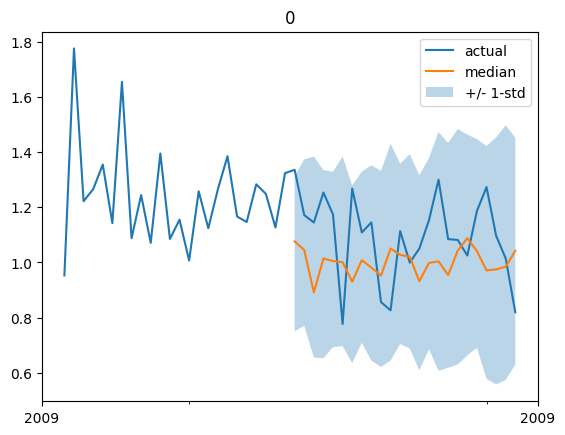

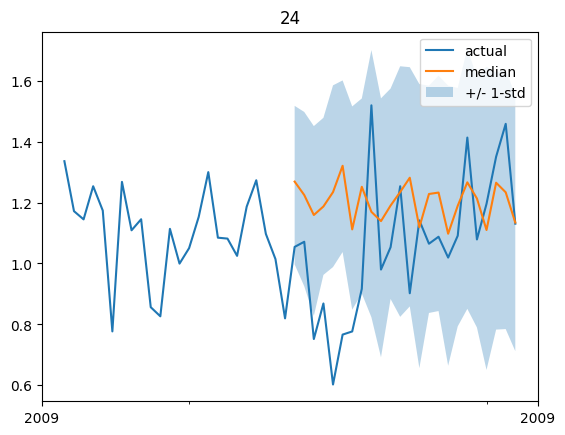

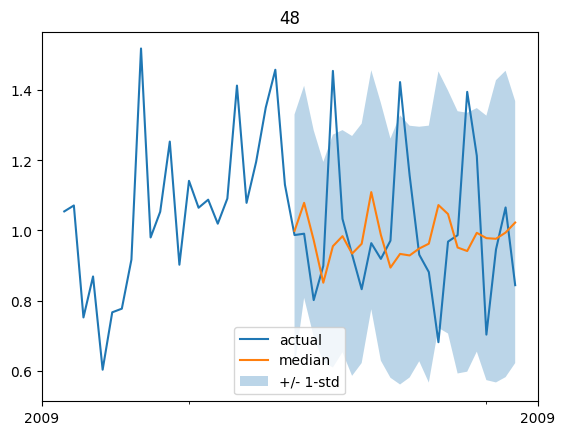

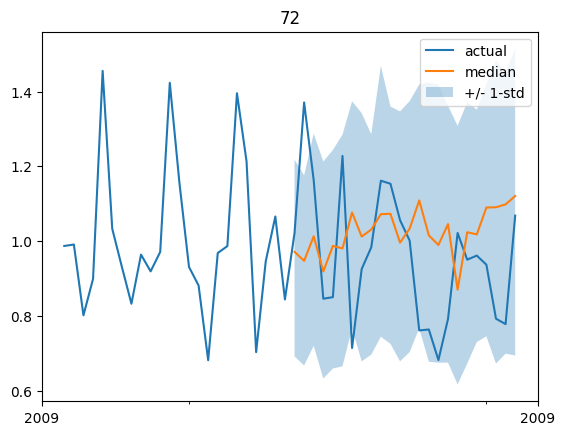

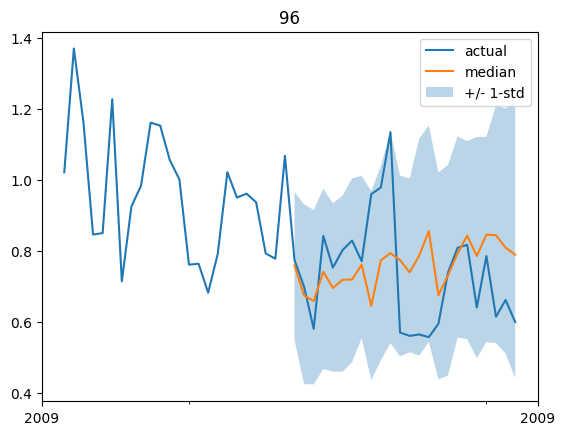

193

In [31]:
import matplotlib.dates as mdates

def plot(ts_index, forecasts):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    plt.title(str(ts_index))
    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()
    
plot(0, forecasts)
plot(prediction_length, forecasts)
plot(prediction_length * 2, forecasts)
plot(prediction_length * 3, forecasts)
plot(prediction_length * 4, forecasts)


len(forecasts)

In [32]:
import random 
def plot_randomly(forecasts):
    plot(random.randint(0, len(forecasts) - 1), forecasts)
    

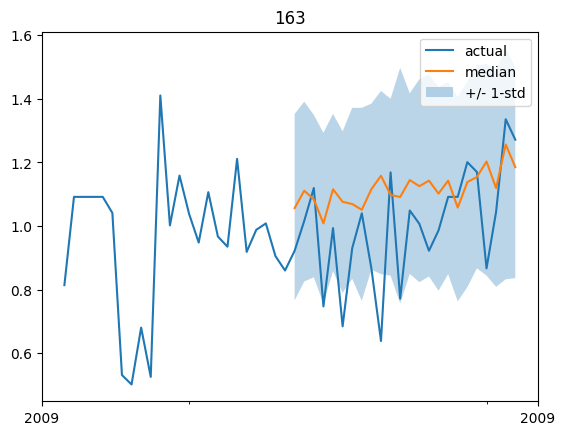

In [48]:
plot_randomly(forecasts)


In [23]:

# # Try with epoch of 20 

# TODO: does the model's parameters reset when I pass it in the training loop again? FIND OUT
model = TimeSeriesTransformerForPrediction(config)
model = train(model, train_dataloader, 10)

-------------TRAINING START-------------
Training with epoch: 10
1.623398780822754
0.5721130967140198


KeyboardInterrupt: 

In [42]:
# Testing with different window

config_1 = TimeSeriesTransformerConfig(
    prediction_length=1,
    # # How many inputs the model take into account when 
    context_length=prediction_length * 2, 
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,# TODO: understand this 
    # day of year, day of months, and day of week
    num_time_features=len(time_features),
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],# TODO: understand this 
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32, 
)

model_1 = TimeSeriesTransformerForPrediction(config_1)


config_14 = TimeSeriesTransformerConfig(
    prediction_length=14,
    # # How many inputs the model take into account when 
    context_length=prediction_length * 2, 
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,# TODO: understand this 
    # day of year, day of months, and day of week
    num_time_features=len(time_features),
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],# TODO: understand this 
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32, 
)

model_14 = TimeSeriesTransformerForPrediction(config_14)

config_56 = TimeSeriesTransformerConfig(
    prediction_length=56,
    # # How many inputs the model take into account when 
    context_length=prediction_length * 2, 
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,# TODO: understand this 
    # day of year, day of months, and day of week
    num_time_features=len(time_features),
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],# TODO: understand this 
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32, 
)

model_56 = TimeSeriesTransformerForPrediction(config_56)

In [43]:
model_1 = train(model_1, train_dataloader, 5)
model_14 = train(model_14, train_dataloader, 5)
model_56 = train(model_56, train_dataloader, 5)

-------------TRAINING START-------------
Training with epoch: 5


ValueError: input length 49 and time feature lengths 72 does not match

In [ ]:

forecasts_test = evaluate(model, test_dataloader) 

In [ ]:

train_dataloader_eval = create_test_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=64,
)
forecasts_train = evaluate(model, train_dataloader_eval)

In [ ]:

mse_metrics_train, mase_metrics_train, smape_metrics_train = calculate(forecasts_train, train_dataset)   

In [ ]:

 
mse_metrics_test, mase_metrics_test, smape_metrics_test = calculate(forecasts_test, test_dataset)  

In [ ]:

print(f"Train MSE: {np.mean(mse_metrics_train)}")
print(f"Test MSE: {np.mean(mse_metrics_test)}")
print(f"Train MASE: {np.mean(mase_metrics_train)}")
print(f"Test MASE: {np.mean(mase_metrics_test)}")
print(f"Train sMAPE: {np.mean(smape_metrics_train)}")
print(f"Test sMAPE: {np.mean(smape_metrics_test)}")

Train MSE: 0.1016107306770977
Test MSE: 0.07031509309540471
Train MASE: 0.9560396630533824
Test MASE: 1.1003828219742027
Train sMAPE: 0.27435744239020354
Test sMAPE: 0.23152500989246366


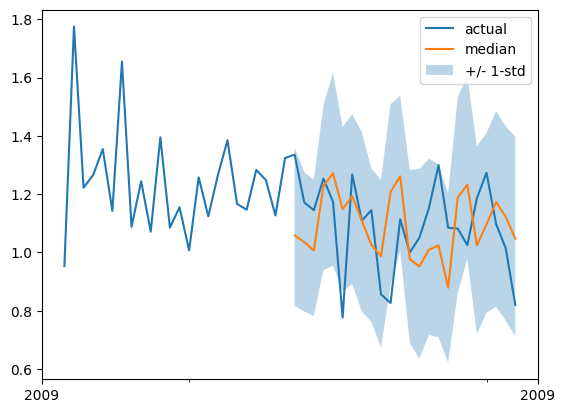

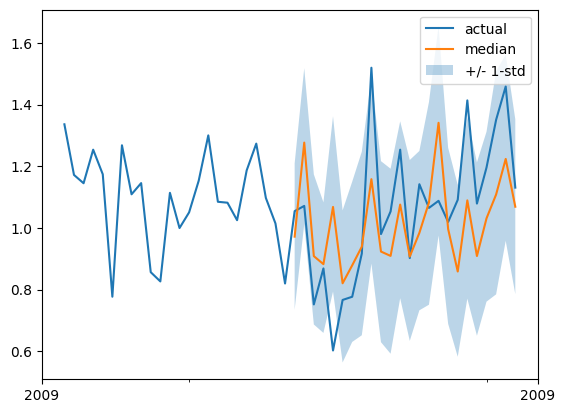

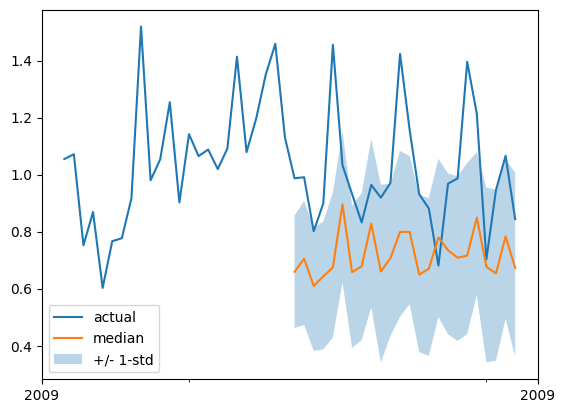

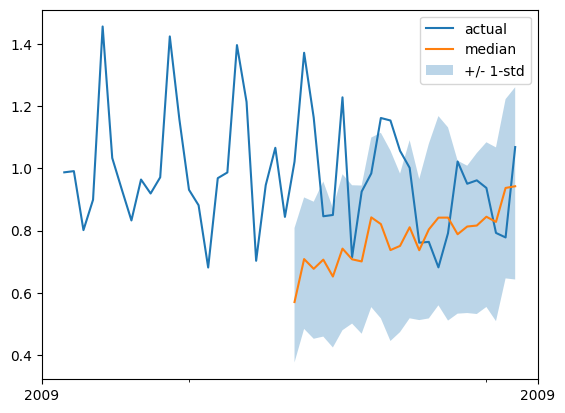

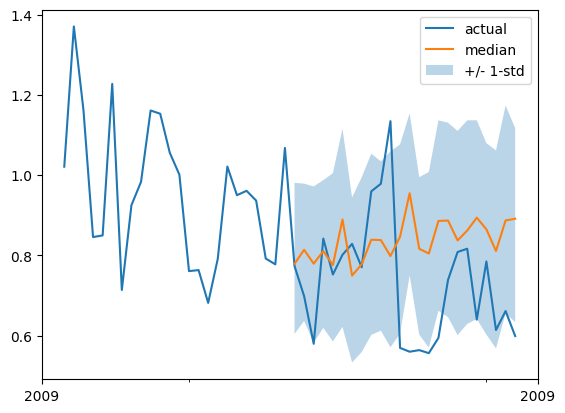

In [ ]:

plot(0, forecasts_train)
plot(prediction_length, forecasts_train)
plot(prediction_length * 2, forecasts_train)
plot(prediction_length * 3, forecasts_train)
plot(prediction_length * 4, forecasts_train)

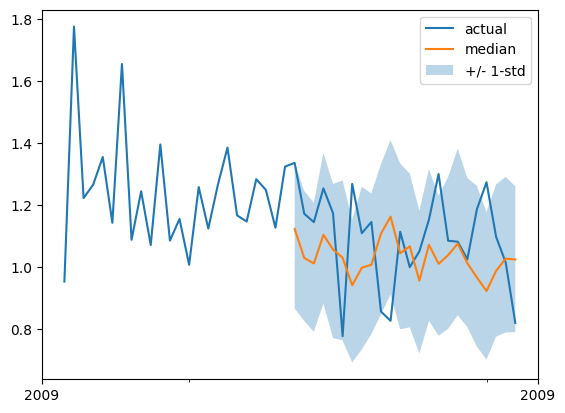

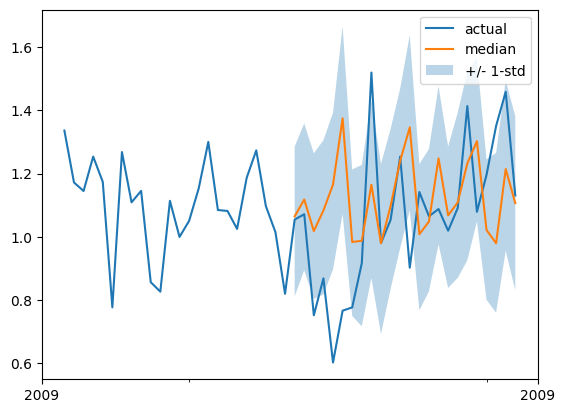

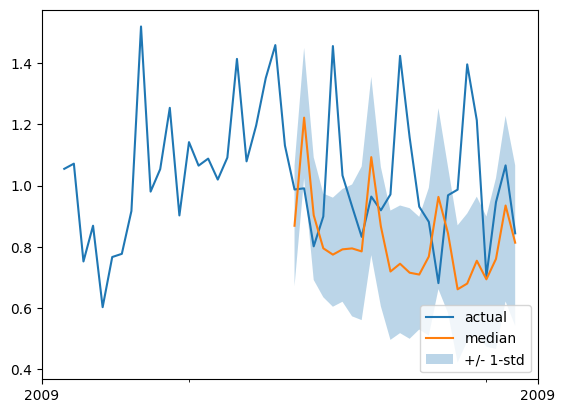

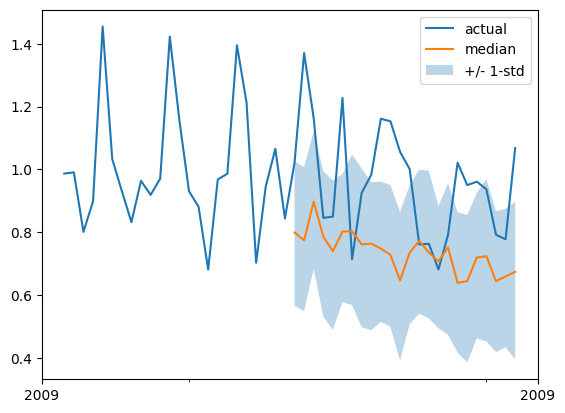

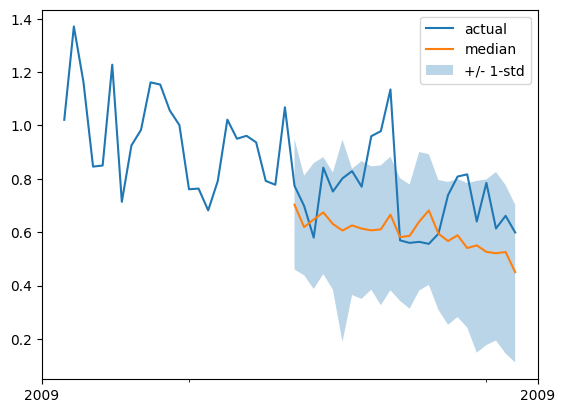

In [ ]:

plot(0, forecasts_test)
plot(prediction_length, forecasts_test)
plot(prediction_length * 2, forecasts_test)
plot(prediction_length * 3, forecasts_test)
plot(prediction_length * 4, forecasts_test)